In [ ]:
! pip install scikit-plot

In [ ]:
import numpy as np
import scikitplot
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import seaborn as sns
from scipy import stats
import json
import ast
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix


from tqdm import tqdm
import itertools
from sklearn.metrics import classification_report

import cv2
import os
from keras.layers import Dropout, BatchNormalization, Activation, GlobalAveragePooling2D

from sklearn.model_selection import train_test_split
import copy


In [ ]:
# !gdown --id 1E8wYbwR2ntXlbUx7zaMfOx0nMaxirVJP

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1E8wYbwR2ntXlbUx7zaMfOx0nMaxirVJP 



In [ ]:
# This is to be executed when woring with colab with the corresponding url

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
 # Main account
url_1 = '/content/drive/MyDrive/2. Relevant Projects/1. Emotions Recognition/Dataset'  ## Colab Drive URL
url_2 = '/content/drive/MyDrive/2. Relevant Projects/1. Emotions Recognition'  ## Colab Drive URL

#url_0 = '/kaggle/input/ferdata'    ##Kaggle url

In [ ]:
 # Account 2 - 3 -4
url_1 = '/content/drive/MyDrive/1. Emotions Recognition/Dataset'  ## Colab Drive URL
url_2 = '/content/drive/MyDrive/1. Emotions Recognition'  ## Colab Drive URL

# I. Data Loading

In [ ]:
train_dir = url_1 +'/train'
test_dir = url_1 + '/test'

train_Edge = url_2 + '/Edge_Prewitt'
train_Gauss = url_2 + '/Gauss'
train_RGB = url_2 + '/RGB'
train_YCBR = url_2 + '/YCBR'
train_YES = url_2 + '/YES'


In [ ]:
def load_data(dir_path, ohe, img_size=(48,48)):
    X = []  # contains images' arrays
    Y = []  # contains images' one hot encoded value
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path

            for file in os.listdir(dir_path +'/'+ path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path +'/'+ path + '/' + file)
                    X.append(img)
                    Y.append(ohe[path])
                    i += 1


    X = np.array(X)
    Y = np.array(Y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, Y, labels

In [ ]:
ohe = {'angry' : 1, 'disgust': 2,'fear' : 3, 'happy': 4, 'neutral': 5,'sad' : 6, 'surprise': 7}

In [ ]:
if tf.test.gpu_device_name() == '':
    print('No GPU found. Make sure to change the runtime type.')
else:
    print('GPU device found:', tf.test.gpu_device_name())


GPU device found: /device:GPU:0


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '':
    print('Using GPU:', device_name)
else:
    print('GPU not found')


Using GPU: /device:GPU:0


### Original & treated images loading

In [ ]:
X_train, Y_train, labels_tr = load_data(train_dir,ohe)

100%|██████████| 7/7 [13:24<00:00, 114.97s/it]

28771 images loaded from /content/drive/MyDrive/1. Emotions Recognition/Dataset/train directory.


In [ ]:
X_train.shape

In [ ]:
Y_train_one_hot = tf.keras.utils.to_categorical(Y_train - 1, num_classes=7)
print(Y_train_one_hot.shape)

(28771, 7)


test data loading & one hot Encoding

In [ ]:
X_test, Y_test,labels_ts = load_data(test_dir, ohe)

Y_test_one_hot = tf.keras.utils.to_categorical(Y_test - 1, num_classes=7)

100%|██████████| 7/7 [02:48<00:00, 24.11s/it]

7208 images loaded from /content/drive/MyDrive/1. Emotions Recognition/Dataset/test directory.


Gauss loading & one hot Encoding

In [ ]:
X_Gauss, Y_Gauss,_= load_data(train_Gauss,ohe)

 57%|█████▋    | 4/7 [05:46<04:18, 86.18s/it]

In [ ]:
Y_Gauss_one_hot = tf.keras.utils.to_categorical(Y_Gauss - 1, num_classes=7)
X_Gauss.shape

Edge loading & one hot Encoding

In [ ]:
X_Edge, Y_Edge, _ = load_data(train_Edge,ohe)

In [ ]:
Y_Edge_one_hot = tf.keras.utils.to_categorical(Y_Edge - 1, num_classes=7)

YCBR loading & one hot Encoding

In [ ]:
X_YCBR, Y_YCBR, _ = load_data(train_YCBR,ohe)

100%|██████████| 7/7 [07:32<00:00, 64.69s/it]

27388 images loaded from /content/drive/MyDrive/1. Emotions Recognition/YCBR directory.


In [ ]:
Y_YCBR_one_hot = tf.keras.utils.to_categorical(Y_YCBR - 1, num_classes=7)
X_YCBR.shape

(27388, 48, 48, 3)

YES loading & one hot Encoding

In [ ]:
X_YES, Y_YES ,_= load_data(train_YES,ohe)

100%|██████████| 7/7 [08:26<00:00, 72.35s/it]

28771 images loaded from /content/drive/MyDrive/1. Emotions Recognition/YES directory.


In [ ]:
Y_YES_one_hot = tf.keras.utils.to_categorical(Y_YES - 1, num_classes=7)

### Image Path generation

In [ ]:
def img_path(dir_path, img_size=(48,48)) : # returns an array of image paths
    X_img_names = []
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
              for file in os.listdir(dir_path +'/'+ path):
                if not file.startswith('.'):
                    X_img_names.append(dir_path +'/'+ path + '/' + file)

    X_img_names = np.array(X_img_names)
    return X_img_names

In [ ]:
X_img_names = img_path(test_dir, img_size=(48,48))

100%|██████████| 7/7 [00:21<00:00,  3.02s/it]


In [ ]:
X_rgb_names = img_path(train_RGB, img_size=(48,48))

# II. Data Splitting & Normalization

## 1. original train & test

In [ ]:
x_train, x_val, y_train_ohe, y_val = train_test_split(X_train, Y_train_one_hot, test_size=0.25, random_state=42)

In [ ]:
x_train, x_val = x_train/255., x_val/255.

In [ ]:
X_test = X_test / 255

## 2. ohe

In [ ]:
y_val_one_hot = tf.keras.utils.to_categorical(y_val - 1, num_classes=7)

print(y_val_one_hot.shape)


(7193, 7, 7)


In [ ]:
y_train_ohee=tf.keras.utils.to_categorical(y_train_ohe, num_classes=7)
y_train_ohee.shape

In [ ]:
y_val_one_hot

array([[[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
#x_train.shape
#y_train.shape
#y_val.shape

(21578, 48, 48, 3)

# **A. CNN MODEL**

# I. Initial model & updates based on original grayscale pictures

## I.1. Fitting on initial model

In [ ]:
# model 1
model_1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(256, 3, activation='relu', input_shape=(48,48,3)),
  BatchNormalization(name='batchNorm_0'),
  Dropout(0.4, name='dropout_0'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_1'),
  Dropout(0.4, name='dropout_1'),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_3'),
  Dropout(0.4, name='dropout_3'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  BatchNormalization(name='batchNorm_2'),
  Dropout(0.4, name='dropout_2'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64 ,activation='relu'),
  tf.keras.layers.Dense(7,activation='softmax')
])


In [ ]:
model_1.compile(
  optimizer='adam',
  #loss=tf.keras.losses.MeanSquaredError(),
  loss='categorical_crossentropy',
  metrics=['accuracy'])
# metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [ ]:
history_1 = model_1.fit(
  x_train,
  y_train_ohe,
  epochs=70,
  batch_size=128,
  validation_data=(x_val, y_val_one_hot)
)

history_dict = history_1.history
history_dict.keys()

Epoch 1/70
169/169 [==============================] - 30s 132ms/step - loss: 1.9074 - accuracy: 0.3076 - val_loss: 1.7892 - val_accuracy: 0.2443
Epoch 2/70
169/169 [==============================] - 20s 118ms/step - loss: 1.5186 - accuracy: 0.4141 - val_loss: 1.8116 - val_accuracy: 0.2742
Epoch 3/70
169/169 [==============================] - 20s 116ms/step - loss: 1.3984 - accuracy: 0.4621 - val_loss: 1.8880 - val_accuracy: 0.2896
Epoch 4/70
169/169 [==============================] - 20s 117ms/step - loss: 1.3066 - accuracy: 0.4976 - val_loss: 1.7799 - val_accuracy: 0.3761
Epoch 5/70
169/169 [==============================] - 19s 115ms/step - loss: 1.2332 - accuracy: 0.5312 - val_loss: 1.6211 - val_accuracy: 0.4128
Epoch 6/70
169/169 [==============================] - 20s 117ms/step - loss: 1.1462 - accuracy: 0.5624 - val_loss: 2.0301 - val_accuracy: 0.3834
Epoch 7/70
169/169 [==============================] - 20s 116ms/step - loss: 1.0772 - accuracy: 0.5905 - val_loss: 1.7923 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
model_1_json = model_1.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_1_json)

model_1.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


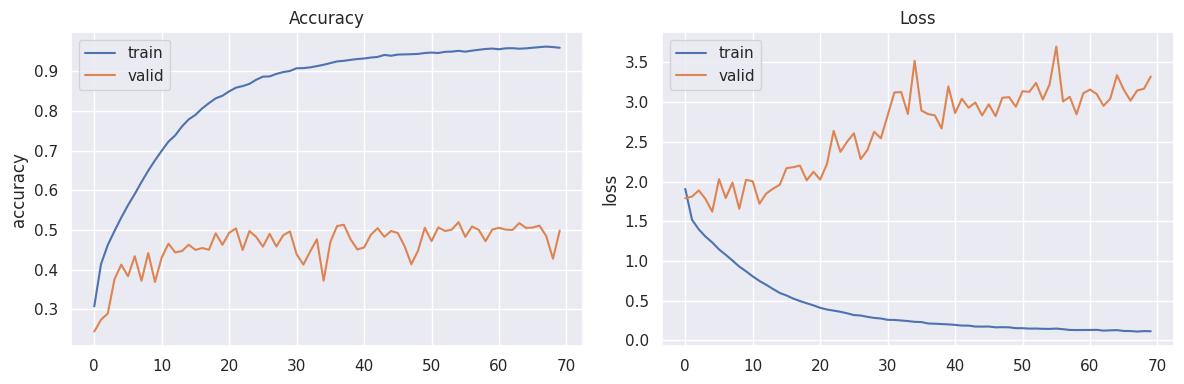

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(data=history_dict, x=history_1.epoch, y='accuracy', label='train')
sns.lineplot(data=history_dict, x=history_1.epoch, y='val_accuracy', label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=history_dict, x=history_1.epoch, y='loss', label='train')
sns.lineplot(data=history_dict, x=history_1.epoch, y='val_loss', label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_1.png')
plt.show()

### **Curve Interpretation**

Training accuracy grows exponentially reaching 95% , whilst validation accuracy plateaus at at around 0.48, it keeps varying between 0.45 and 0.51, where at the end, after reaching its highest value 0.51, it drops again.

The loss function drops logarithmically approximating for training but grows up from 2 to 3.5 for validation.

This is due to overfitting, we will set the initial learning rate to a relatively low value, increase dropout, and add a maxpooling layer.

In [ ]:
yhat_test = model_1.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(Y_test_one_hot, axis=1), yhat_test ,figsize=(7,7))
plt.savefig("confusion_matrix_1.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(Y_test_one_hot, axis=1) != yhat_test)}\n\n')
print(classification_report(np.argmax(Y_test_one_hot, axis=1), yhat_test))

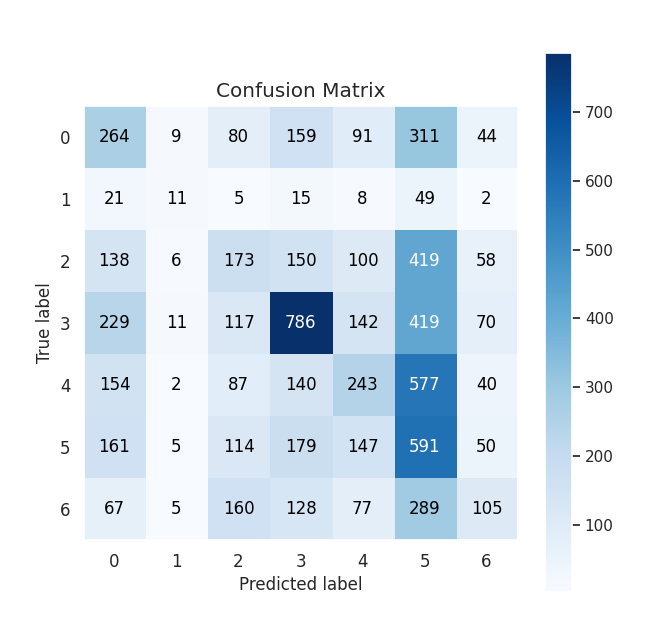

### **Confusion Matrix interpretation**
The highest identification rate is 50% for the label 'happy' which makes sense given its high number of samples and unique characteristics on grayscale images.

The lowest scoring class in terms of precision is disgust, that is be it correct or wrong identifications, which is predictible given its hugely small sample size, it scores very low on recall as well for the same reason.

The model's highest error tends to be in the 5th label column : 'sad', many images are predicted as 'sad',

-----------------------------------------------


### Observations and conclusions : Model_1

Case of overfitting, we will

- set initial learning rate to 0.0005
- increase dropout to 0.65-0.7
- and add 2 maxpooling layers

*The updated model is Model_11_update*

## I.2. Updated model :  Model_11_update

In [ ]:
# model 11 update
Model_11_update = tf.keras.Sequential([
  tf.keras.layers.Conv2D(256, 3, activation='relu', input_shape=(48,48,3)),
  BatchNormalization(name='batchNorm_0'),
  Dropout(0.65, name='dropout_0'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_1'),
  Dropout(0.7, name='dropout_1'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_3'),
  Dropout(0.6, name='dropout_3'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  BatchNormalization(name='batchNorm_2'),
  Dropout(0.7, name='dropout_2'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64 ,activation='relu'),
  tf.keras.layers.Dense(7,activation='softmax')
])


In [ ]:
Model_11_update.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
history_11 = Model_11_update.fit(
  x_train,
  y_train_ohe,
  epochs=100,
  batch_size=128,
  validation_data=(x_val, y_val_one_hot)
)

history_11_dict = history_11.history

Epoch 1/100
169/169 [==============================] - 18s 108ms/step - loss: 1.0492 - accuracy: 0.6018 - val_loss: 1.2213 - val_accuracy: 0.5357
Epoch 2/100
169/169 [==============================] - 17s 98ms/step - loss: 1.0488 - accuracy: 0.6017 - val_loss: 1.2063 - val_accuracy: 0.5334
Epoch 3/100
169/169 [==============================] - 17s 103ms/step - loss: 1.0425 - accuracy: 0.6063 - val_loss: 1.3651 - val_accuracy: 0.4705
Epoch 4/100
169/169 [==============================] - 18s 108ms/step - loss: 1.0462 - accuracy: 0.6078 - val_loss: 1.2838 - val_accuracy: 0.5131
Epoch 5/100
169/169 [==============================] - 18s 105ms/step - loss: 1.0408 - accuracy: 0.6073 - val_loss: 1.2067 - val_accuracy: 0.5351
Epoch 6/100
169/169 [==============================] - 17s 99ms/step - loss: 1.0363 - accuracy: 0.6114 - val_loss: 1.2380 - val_accuracy: 0.5205
Epoch 7/100
169/169 [==============================] - 17s 99ms/step - loss: 1.0349 - accuracy: 0.6141 - val_loss: 1.1603 - va

In [ ]:
model_11_json = Model_11_update.to_json()
with open("model_11.json", "w") as json_file:
    json_file.write(model_11_json)

Model_11_update.save("model_11.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


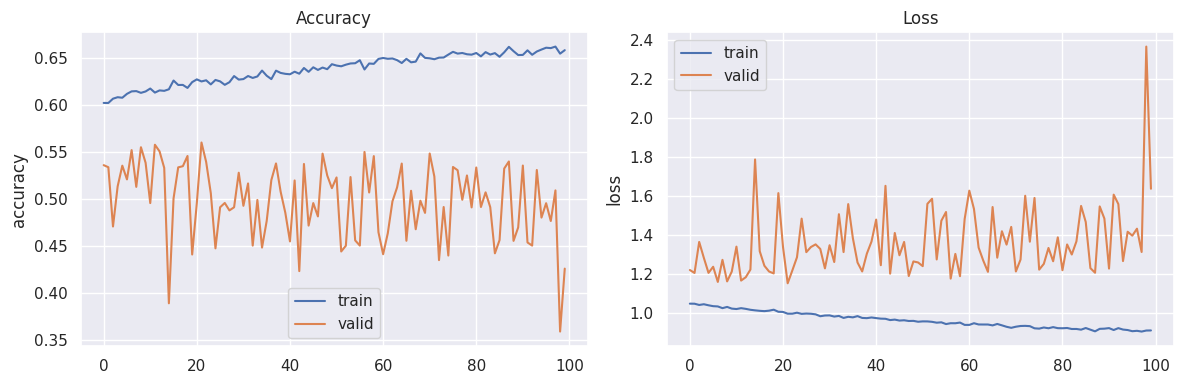

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(data=history_11_dict, x=history_11.epoch, y='accuracy', label='train')
sns.lineplot(data=history_11_dict, x=history_11.epoch, y='val_accuracy', label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=history_11_dict, x=history_11.epoch, y='loss', label='train')
sns.lineplot(data=history_11_dict, x=history_11.epoch, y='val_loss', label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_11.png')
plt.show()

### **Curve Interpreatation**
The validation loss is swaying between 1.1 and 1.6, the training loss is decreasing very slowly almost constant.
The training accuracy rises slower from 0.6 to 0.65, however the validation accuracy sways around 0.5 and reachs higher values, top at 56% .

**==> The model is no longer overfitting the data, but it's no longer converging because the learning rate is too small.**

**We'll attempt to increase the learning rate slightly in order to make the model converge just right.**

226/226 [==============================] - 1s 4ms/step
Total wrong validation predictions: 5103


              precision    recall  f1-score   support

           0       0.20      0.69      0.31       958
           1       0.00      0.00      0.00       111
           2       0.22      0.11      0.15      1044
           3       0.39      0.72      0.50      1774
           4       0.50      0.00      0.00      1243
           5       0.57      0.03      0.06      1247
           6       0.31      0.00      0.01       831

    accuracy                           0.29      7208
   macro avg       0.31      0.22      0.15      7208
weighted avg       0.37      0.29      0.20      7208



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


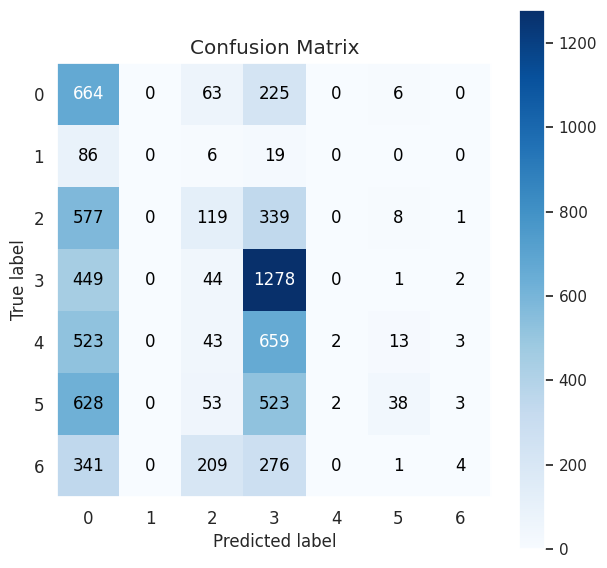

In [ ]:
yhat_test = Model_11_update.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(Y_test_one_hot, axis=1), yhat_test ,figsize=(7,7))
plt.savefig("confusion_matrix_11.png")

print(f'Total wrong validation predictions: {np.sum(np.argmax(Y_test_one_hot, axis=1) != yhat_test)}\n\n')
print(classification_report(np.argmax(Y_test_one_hot, axis=1), yhat_test))

### **Matrix interpretation**
Best values : anger & happiness; could be explained by their distinct features on the face particularly in untreated & low resolution data.

## I.3. Updated model 2

In [ ]:
# model loading from hdf
# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')

In [ ]:
# model 2 update
Model_12_update = tf.keras.Sequential([
  tf.keras.layers.Conv2D(256, 3, activation='relu', input_shape=(48,48,3)),
  BatchNormalization(name='batchNorm_0'),
  Dropout(0.65, name='dropout_0'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_1'),
  Dropout(0.7, name='dropout_1'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_3'),
  Dropout(0.6, name='dropout_3'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  BatchNormalization(name='batchNorm_2'),
  Dropout(0.7, name='dropout_2'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64 ,activation='relu'),
  tf.keras.layers.Dense(7,activation='softmax')
])


In [ ]:
Model_12_update.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
history_12 = Model_12_update.fit(
  x_train,
  y_train_ohe,
  epochs=100,
  batch_size=128,
  validation_data=(x_val, y_val)
)

history_dict = history_12.history

Epoch 1/100
163/163 [==============================] - 28s 115ms/step - loss: 2.2915 - accuracy: 0.2165 - val_loss: 2.0463 - val_accuracy: 0.1724
Epoch 2/100
163/163 [==============================] - 17s 103ms/step - loss: 1.9249 - accuracy: 0.2375 - val_loss: 2.2157 - val_accuracy: 0.1967
Epoch 3/100
163/163 [==============================] - 16s 100ms/step - loss: 1.8404 - accuracy: 0.2630 - val_loss: 2.2986 - val_accuracy: 0.2122
Epoch 4/100
163/163 [==============================] - 17s 104ms/step - loss: 1.7840 - accuracy: 0.2866 - val_loss: 2.4190 - val_accuracy: 0.2380
Epoch 5/100
163/163 [==============================] - 17s 104ms/step - loss: 1.7454 - accuracy: 0.3012 - val_loss: 2.1945 - val_accuracy: 0.2338
Epoch 6/100
163/163 [==============================] - 16s 101ms/step - loss: 1.7077 - accuracy: 0.3221 - val_loss: 2.3929 - val_accuracy: 0.2472
Epoch 7/100
163/163 [==============================] - 17s 103ms/step - loss: 1.6693 - accuracy: 0.3436 - val_loss: 1.8045 -

In [ ]:
model_12_json = Model_12_update.to_json()
with open("model_12.json", "w") as json_file:
    json_file.write(model_12_json)

Model_12_update.save("model_12.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


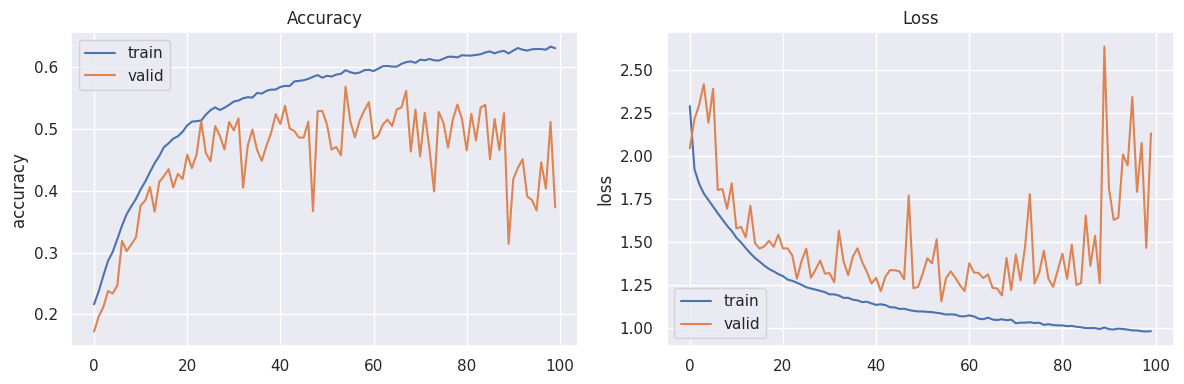

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(data=history_dict, x=history_12.epoch, y='accuracy', label='train')
sns.lineplot(data=history_dict, x=history_12.epoch, y='val_accuracy', label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=history_dict, x=history_12.epoch, y='loss', label='train')
sns.lineplot(data=history_dict, x=history_12.epoch, y='val_loss', label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_12.png')
plt.show()

### **Curve Interpretation**
The training and validation loss are dropping consistently,
The training accuracy rises slower and reaches lower values relative to the initial model, however the validation accuracy rises more consistently and reachs higher values.
The model is just right

The training accuracy now does not surpass 70% however the validation accuracy now rises above 50% more consistently and reaches its peak at the 90th epoch with value 56%.

The validation loss peaks at the 5th epoch then drops swaying around 1.4.

**The model starts to overfit after the 50th epoch. We could use Earlystopping.**

The results are somewhat acceptable for completely untreated data.

226/226 [==============================] - 1s 5ms/step
Total wrong validation predictions: 5310


              precision    recall  f1-score   support

           0       0.21      0.32      0.25       958
           1       0.00      0.00      0.00       111
           2       0.18      0.57      0.28      1044
           3       0.42      0.47      0.44      1774
           4       0.00      0.00      0.00      1243
           5       0.33      0.13      0.19      1247
           6       0.67      0.00      0.01       831

    accuracy                           0.26      7208
   macro avg       0.26      0.21      0.17      7208
weighted avg       0.29      0.26      0.22      7208



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


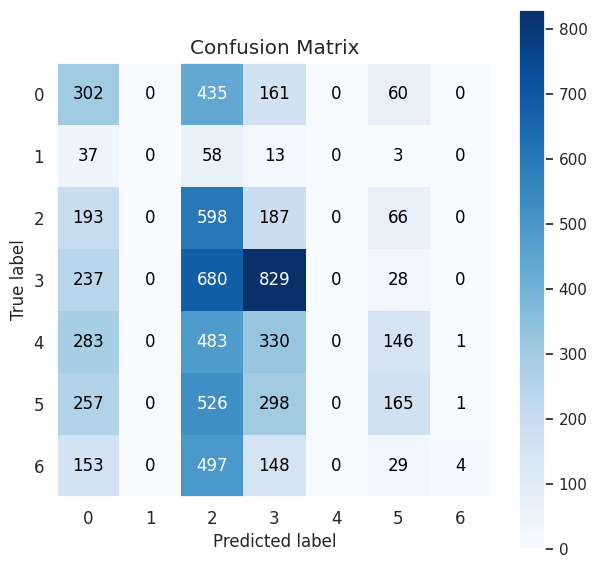

In [ ]:
yhat_test = Model_12_update.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(Y_test_one_hot, axis=1), yhat_test ,figsize=(7,7))
plt.savefig("confusion_matrix_12.png")

print(f'Total wrong validation predictions: {np.sum(np.argmax(Y_test_one_hot, axis=1) != yhat_test)}\n\n')
print(classification_report(np.argmax(Y_test_one_hot, axis=1), yhat_test))

### **Matrix Interpretation**
It does particularly well in detecting fear emotion.

------------------------------------------------------------------------------------------

# II. Fitting on Initially preprocessed data    

We will use the 2nd update of the CNN model, as the model for training for all 4 different datasets and comapre the results of the preprocessing effect.

a. Gaussian dataset

b. Edge Detetion dataset

c. YCbCr images

d. YES images

## 1 . Gaussian dataset

In [ ]:
X_Gauss = X_Gauss/255.

In [ ]:
# model 2
Model_2 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(256, 3, activation='relu', input_shape=(48,48,3)),
  BatchNormalization(name='batchNorm_0'),
  Dropout(0.65, name='dropout_0'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_1'),
  Dropout(0.7, name='dropout_1'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_3'),
  Dropout(0.6, name='dropout_3'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  BatchNormalization(name='batchNorm_2'),
  Dropout(0.7, name='dropout_2'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64 ,activation='relu'),
  tf.keras.layers.Dense(7,activation='softmax')
])

In [ ]:
Model_2.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
y_val_one_hot.shape

(7193, 7, 7)

In [ ]:
history_2 = Model_2.fit(
  X_Gauss,
  Y_Gauss_one_hot,
  epochs=100,
  batch_size=128,
  validation_data=(x_val, y_val)
)

history_dict_2 = history_2.history

The model's validation accuracy peaks at the 74th epoch reaching 52%

### **Testing Model 2**

In [ ]:
model_2_json = Model_2.to_json()
with open("model_2.json", "w") as json_file:
    json_file.write(model_2_json)

model_2_json.save("model_2.h5")

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(data=history_dict_2, x=history_2.epoch, y='accuracy', label='train')
sns.lineplot(data=history_dict_2, x=history_2.epoch, y='val_accuracy', label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=history_dict_2, x=history_2.epoch, y='loss', label='train')
sns.lineplot(data=history_dict_2, x=history_2.epoch, y='val_loss', label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_2.png')
plt.show()

In [ ]:
yhat_test = Model_2.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(Y_test_one_hot, axis=1), yhat_test ,figsize=(7,7))
plt.savefig("confusion_matrix_2.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(Y_test_one_hot, axis=1) != yhat_test)}\n\n')
print(classification_report(np.argmax(Y_test_one_hot, axis=1), yhat_test))

## 2 . Edge Dataset : Model_2_Edge

In [ ]:
X_Edge = X_Edge/255.

In [ ]:
# model 2
Model_2_edge = tf.keras.Sequential([
  tf.keras.layers.Conv2D(256, 3, activation='relu', input_shape=(48,48,3)),
  BatchNormalization(name='batchNorm_0'),
  Dropout(0.65, name='dropout_0'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_1'),
  Dropout(0.7, name='dropout_1'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_3'),
  Dropout(0.6, name='dropout_3'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  BatchNormalization(name='batchNorm_2'),
  Dropout(0.7, name='dropout_2'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64 ,activation='relu'),
  tf.keras.layers.Dense(7,activation='softmax')
])


In [ ]:
Model_2_edge.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
history_2_edge = Model_2_edge.fit(
  X_Edge,
  Y_Edge_one_hot,
  epochs=100,
  batch_size=128,
  validation_data=(x_val, y_val_one_hot)
)

history_dict_2_edge = history_2_edge.history

### **Testing model_2_edge**

In [ ]:
Model_2_Edge_json = Model_2_Edge.to_json()
with open("Model_2_Edge.json", "w") as json_file:
    json_file.write(model_2_json)

Model_2_Edge_json.save("Model_2_Edge.h5")

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(data=history_dict_2_edge, x=history_2_edge.epoch, y='accuracy', label='train')
sns.lineplot(data=history_dict_2_edge, x=history_2_edge.epoch, y='val_accuracy', label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=history_dict_2_edge, x=history_2_edge.epoch, y='loss', label='train')
sns.lineplot(data=history_dict_2_edge, x=history_2_edge.epoch, y='val_loss', label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_1.png')
plt.show()

In [ ]:
yhat_test = Model_2_edge.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(Y_test_one_hot, axis=1), yhat_test ,figsize=(7,7))
plt.savefig("confusion_matrix_2_edge.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(Y_test_one_hot, axis=1) != yhat_test)}\n\n')
print(classification_report(np.argmax(Y_test_one_hot, axis=1), yhat_test))

## 3 . YCbCr images : Model_3

In [ ]:
X_YCBR = X_YCBR/255.

In [ ]:
# model 3 update
Model_3 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(256, 3, activation='relu', input_shape=(48,48,3)),
  BatchNormalization(name='batchNorm_0'),
  Dropout(0.65, name='dropout_0'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_1'),
  Dropout(0.7, name='dropout_1'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_3'),
  Dropout(0.6, name='dropout_3'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  BatchNormalization(name='batchNorm_2'),
  Dropout(0.7, name='dropout_2'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64 ,activation='relu'),
  tf.keras.layers.Dense(7,activation='softmax')
])


In [ ]:
Model_3.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
history_3 = Model_3.fit(
  X_YCBR,
  Y_YCBR_one_hot,
  epochs=50,
  batch_size=128,
  validation_data=(x_val, y_val)
)

history_dict_3 = history_3.history

Epoch 1/50
214/214 [==============================] - 26s 106ms/step - loss: 2.2650 - accuracy: 0.1980 - val_loss: 1.9570 - val_accuracy: 0.2024
Epoch 2/50
214/214 [==============================] - 22s 101ms/step - loss: 1.9091 - accuracy: 0.2310 - val_loss: 2.0791 - val_accuracy: 0.1732
Epoch 3/50
214/214 [==============================] - 21s 100ms/step - loss: 1.8244 - accuracy: 0.2584 - val_loss: 2.2934 - val_accuracy: 0.1795
Epoch 4/50
214/214 [==============================] - 22s 102ms/step - loss: 1.7709 - accuracy: 0.2798 - val_loss: 3.1187 - val_accuracy: 0.1827
Epoch 5/50
214/214 [==============================] - 22s 102ms/step - loss: 1.7392 - accuracy: 0.2960 - val_loss: 3.9125 - val_accuracy: 0.1792
Epoch 6/50
214/214 [==============================] - 22s 102ms/step - loss: 1.7049 - accuracy: 0.3081 - val_loss: 4.1281 - val_accuracy: 0.1806
Epoch 7/50
214/214 [==============================] - 22s 102ms/step - loss: 1.6737 - accuracy: 0.3281 - val_loss: 4.5441 - val_ac

### **Testing Model 3**

In [ ]:
# Save the model architecture as JSON
model_3_json = Model_3.to_json()
with open("model_3.json", "w") as json_file:
    json_file.write(model_3_json)

# Save the model weights
Model_3.save_weights("model_3_weights.h5")


In [ ]:
# Save the entire model to an HDF5 file
Model_3.save("model_3.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


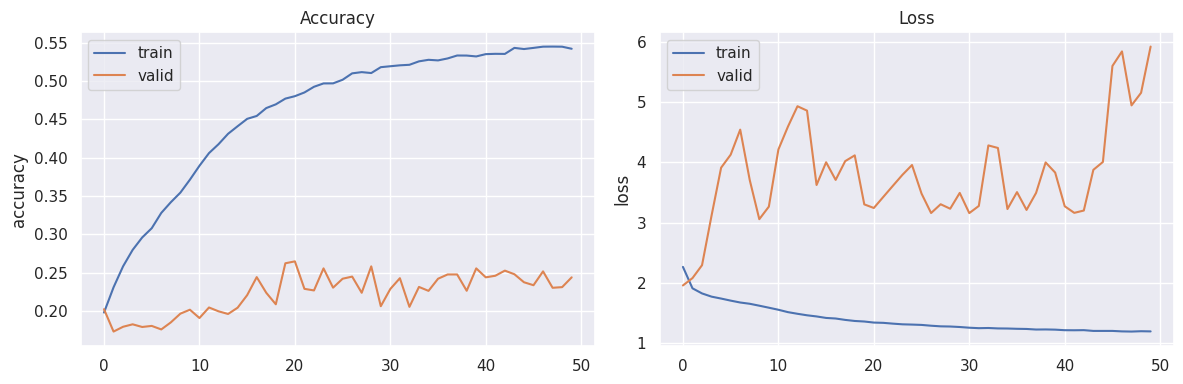

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(data=history_dict_3, x=history_3.epoch, y='accuracy', label='train')
sns.lineplot(data=history_dict_3, x=history_3.epoch, y='val_accuracy', label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=history_dict_3, x=history_3.epoch, y='loss', label='train')
sns.lineplot(data=history_dict_3, x=history_3.epoch, y='val_loss', label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_3.png')
plt.show()

226/226 [==============================] - 2s 5ms/step
total wrong validation predictions: 5441


              precision    recall  f1-score   support

           0       0.21      0.31      0.25       958
           1       0.03      0.04      0.03       111
           2       0.21      0.22      0.21      1044
           3       0.55      0.12      0.19      1774
           4       0.25      0.50      0.33      1243
           5       0.22      0.28      0.25      1247
           6       0.63      0.07      0.12       831

    accuracy                           0.25      7208
   macro avg       0.30      0.22      0.20      7208
weighted avg       0.35      0.25      0.23      7208



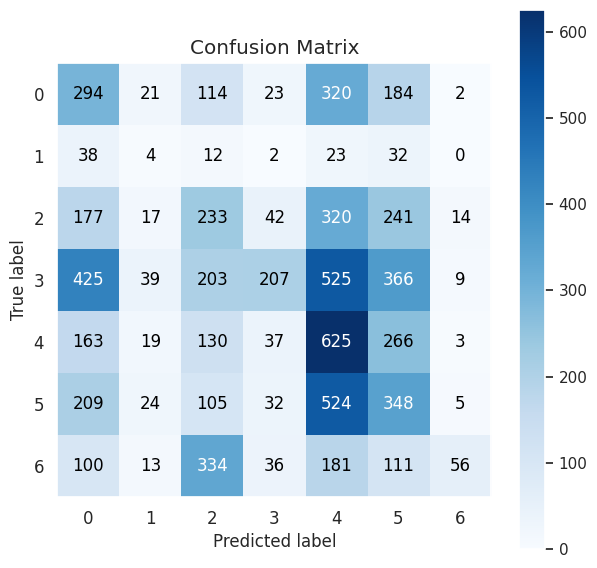

In [ ]:
yhat_test = Model_3.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(Y_test_one_hot, axis=1), yhat_test ,figsize=(7,7))
plt.savefig("confusion_matrix_3.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(Y_test_one_hot, axis=1) != yhat_test)}\n\n')
print(classification_report(np.argmax(Y_test_one_hot, axis=1), yhat_test))

## 4 . YES images : Model_4

In [ ]:
X_YES = X_YES/255.

In [ ]:
# model 4
Model_4 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(256, 3, activation='relu', input_shape=(48,48,3)),
  BatchNormalization(name='batchNorm_0'),
  Dropout(0.65, name='dropout_0'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_1'),
  Dropout(0.7, name='dropout_1'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  BatchNormalization(name='batchNorm_3'),
  Dropout(0.6, name='dropout_3'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  BatchNormalization(name='batchNorm_2'),
  Dropout(0.7, name='dropout_2'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64 ,activation='relu'),
  tf.keras.layers.Dense(7,activation='softmax')
])


In [ ]:
Model_4.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
history_4 = Model_4.fit(
  X_YES,
  Y_YES_one_hot,
  epochs=40,
  batch_size=128,
  validation_data=(x_val, y_val)
)

history_dict_4 = history_4.history

Epoch 1/40
225/225 [==============================] - 29s 111ms/step - loss: 2.1940 - accuracy: 0.2156 - val_loss: 1.9462 - val_accuracy: 0.2509
Epoch 2/40
225/225 [==============================] - 23s 102ms/step - loss: 1.8637 - accuracy: 0.2554 - val_loss: 1.8901 - val_accuracy: 0.2338
Epoch 3/40
225/225 [==============================] - 23s 101ms/step - loss: 1.7793 - accuracy: 0.2897 - val_loss: 1.8023 - val_accuracy: 0.2644
Epoch 4/40
225/225 [==============================] - 23s 101ms/step - loss: 1.7282 - accuracy: 0.3113 - val_loss: 1.8282 - val_accuracy: 0.2044
Epoch 5/40
225/225 [==============================] - 23s 101ms/step - loss: 1.6866 - accuracy: 0.3287 - val_loss: 1.9261 - val_accuracy: 0.1724
Epoch 6/40
225/225 [==============================] - 23s 100ms/step - loss: 1.6572 - accuracy: 0.3456 - val_loss: 1.8817 - val_accuracy: 0.1718
Epoch 7/40
225/225 [==============================] - 22s 99ms/step - loss: 1.6149 - accuracy: 0.3634 - val_loss: 1.8745 - val_acc

### **Testing Model 4**

In [ ]:
# Save the model architecture as JSON
model_4_json = Model_4.to_json()
with open("model_4.json", "w") as json_file:
    json_file.write(model_4_json)

# Save the model weights
Model_4.save_weights("model_4_weights.h5")

# Save the entire model to an HDF5 file
Model_4.save("model_4.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


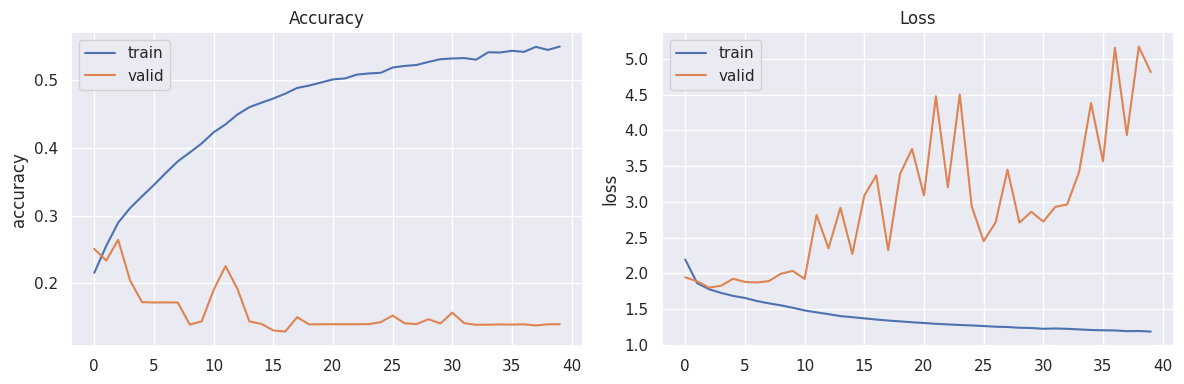

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(data=history_dict_4, x=history_4.epoch, y='accuracy', label='train')
sns.lineplot(data=history_dict_4, x=history_4.epoch, y='val_accuracy', label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=history_dict_4, x=history_4.epoch, y='loss', label='train')
sns.lineplot(data=history_dict_4, x=history_4.epoch, y='val_loss', label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_4.png')
plt.show()

226/226 [==============================] - 1s 4ms/step
total wrong validation predictions: 6250


              precision    recall  f1-score   support

           0       0.13      1.00      0.23       958
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00      1044
           3       0.17      0.00      0.00      1774
           4       0.00      0.00      0.00      1243
           5       0.00      0.00      0.00      1247
           6       0.00      0.00      0.00       831

    accuracy                           0.13      7208
   macro avg       0.04      0.14      0.03      7208
weighted avg       0.06      0.13      0.03      7208



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


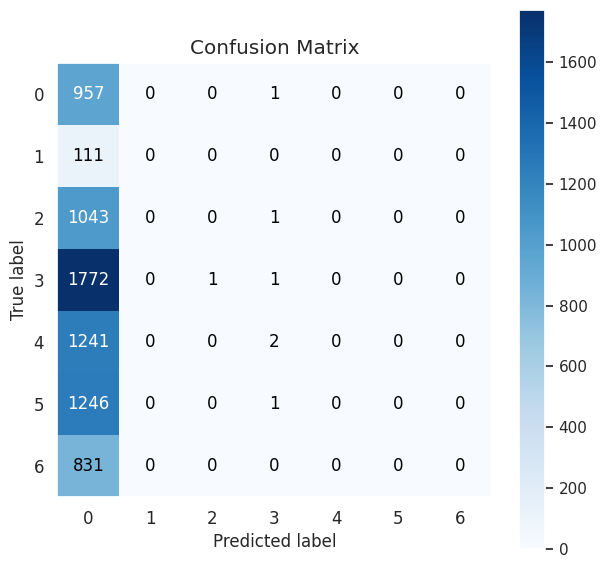

In [ ]:
yhat_test = Model_4.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(Y_test_one_hot, axis=1), yhat_test ,figsize=(7,7))
plt.savefig("confusion_matrix_4.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(Y_test_one_hot, axis=1) != yhat_test)}\n\n')
print(classification_report(np.argmax(Y_test_one_hot, axis=1), yhat_test))

# III. Comparison of validation results based on dataset preprocessing type

a. Grayscale :
- Gives good results for fear and very good results for happy
- Tends to have high fear recall, many emotions are mistakenly classified as fear.

b. YcrCb
-Gives good results for neutral
- Tends to mistake some neutral for sad or happy.

c. YES
- Mistakes Angry for Happy
- Gives good results for angry dataset overall


**==> For the same base model, different image treatements  with color shift makes te model better at identifying a certain emotion, therefore, including the whole modified dataset as input even to a single model, should give a complete result with good accuracy.**

# **B. Transfer Learning MODEL**

##  **1. ResNet model**

In [ ]:
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

x = tf.keras.layers.Flatten()(resnet_model.output)
output_layer = tf.keras.layers.Dense(7, activation='softmax')(x)

model_res = tf.keras.models.Model(inputs=resnet_model.input, outputs=output_layer)

for layer in model_res.layers[:-1]:
    layer.trainable=False

# Printing model summary to see the architecture
#model_res.summary()


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model_res.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print('y_train_ohe.shape =',y_train_ohe.shape )
print('y_val_one_hot.shape =',y_val_one_hot.shape )
print('y_val.shape =',y_val.shape )

y_train_ohe.shape = (21578, 7)
y_val_one_hot.shape = (7193, 7, 7)
y_val.shape = (7193, 7)


In [ ]:
history_resnet = model_res.fit(
      x_train,
      y_train_ohe,
      epochs=50,
      validation_data=(x_val, y_val)
    )

history_resnet_dict = history_resnet.history

Epoch 1/50
675/675 [==============================] - 19s 22ms/step - loss: 1.8254 - accuracy: 0.2586 - val_loss: 1.7960 - val_accuracy: 0.2739
Epoch 2/50
675/675 [==============================] - 12s 18ms/step - loss: 1.7585 - accuracy: 0.2908 - val_loss: 1.7517 - val_accuracy: 0.3004
Epoch 3/50
675/675 [==============================] - 12s 18ms/step - loss: 1.7195 - accuracy: 0.3140 - val_loss: 1.7299 - val_accuracy: 0.3199
Epoch 4/50
675/675 [==============================] - 12s 17ms/step - loss: 1.7050 - accuracy: 0.3260 - val_loss: 1.6945 - val_accuracy: 0.3178
Epoch 5/50
675/675 [==============================] - 13s 20ms/step - loss: 1.6908 - accuracy: 0.3322 - val_loss: 1.7330 - val_accuracy: 0.3277
Epoch 6/50
675/675 [==============================] - 19s 28ms/step - loss: 1.6747 - accuracy: 0.3454 - val_loss: 1.7356 - val_accuracy: 0.3635
Epoch 7/50
675/675 [==============================] - 19s 28ms/step - loss: 1.6728 - accuracy: 0.3456 - val_loss: 1.7905 - val_accuracy:

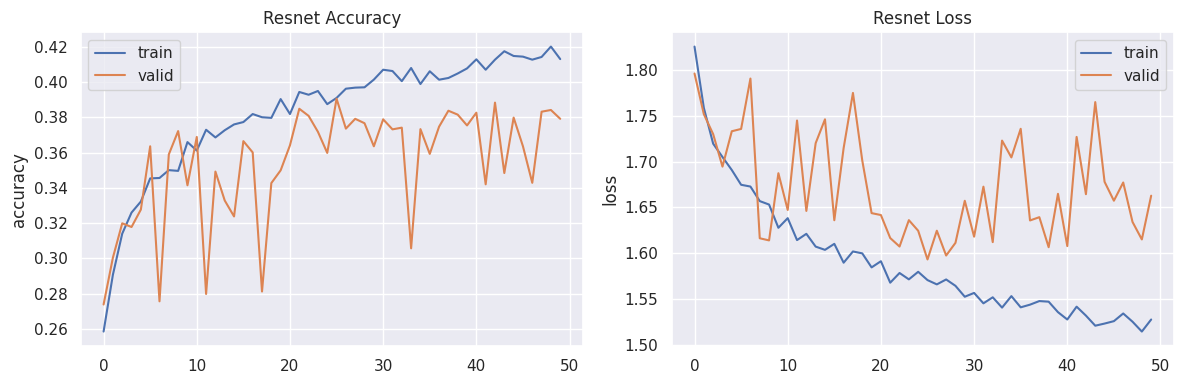

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(data=history_resnet_dict, x=history_resnet.epoch, y='accuracy', label='train')
sns.lineplot(data=history_resnet_dict, x=history_resnet.epoch, y='val_accuracy', label='valid')
plt.title('Resnet Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=history_resnet_dict, x=history_resnet.epoch, y='loss', label='train')
sns.lineplot(data=history_resnet_dict, x=history_resnet.epoch, y='val_loss', label='valid')
plt.title('Resnet Loss')
plt.tight_layout()

plt.savefig('epoch_history_res.png')
plt.show()

==> It seems that the Resnet model is overfitting the data after the 9th epoch, we will finetune it adding dropout and pooling layers, and we'll reduce the number of epochs.

226/226 [==============================] - 4s 14ms/step
total wrong validation predictions: 4507


              precision    recall  f1-score   support

           0       0.24      0.38      0.29       958
           1       0.38      0.05      0.09       111
           2       0.46      0.04      0.08      1044
           3       0.43      0.70      0.53      1774
           4       0.32      0.47      0.38      1243
           5       0.45      0.08      0.14      1247
           6       0.55      0.44      0.49       831

    accuracy                           0.37      7208
   macro avg       0.40      0.31      0.29      7208
weighted avg       0.41      0.37      0.33      7208



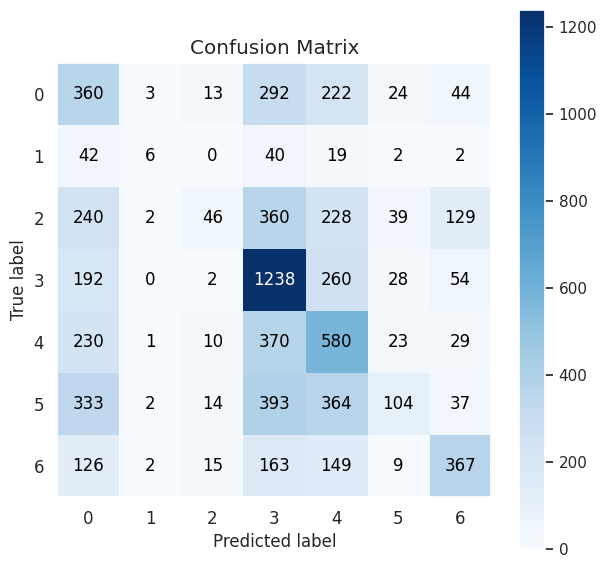

In [ ]:
yhat_vgg_test = model_res.predict(X_test)
yhat_vgg_test = np.argmax(yhat_vgg_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(Y_test_one_hot, axis=1), yhat_vgg_test, figsize=(7,7))
plt.savefig("confusion_matrix_res.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(Y_test_one_hot, axis=1) != yhat_vgg_test)}\n\n')
print(classification_report(np.argmax(Y_test_one_hot, axis=1), yhat_vgg_test))

## **2. RESNET Finetuned**

In [ ]:
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))


x1= tf.keras.layers.GlobalAveragePooling2D()(resnet_model.output)
x3= tf.keras.layers.Dropout(0.4)(x1)
x = tf.keras.layers.Flatten()(x3)
output_layer = tf.keras.layers.Dense(7, activation='softmax')(x)

resnet_model_finetuned = tf.keras.models.Model(inputs=resnet_model.input, outputs=output_layer)

for layer in resnet_model_finetuned.layers[:-4]:
    layer.trainable=False

# Printing model summary to see the architecture
#resnet_model_finetuned.summary()


In [ ]:
resnet_model_finetuned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_resnet_FineTune = resnet_model_finetuned.fit(
      x_train,
      y_train_ohe,
      epochs=20,
      validation_data=(x_val, y_val)
    )

history_resnet_FineTune_dict = history_resnet_FineTune.history

Epoch 1/50
675/675 [==============================] - 20s 24ms/step - loss: 1.8764 - accuracy: 0.2212 - val_loss: 1.7702 - val_accuracy: 0.2668
Epoch 2/50
675/675 [==============================] - 13s 19ms/step - loss: 1.8083 - accuracy: 0.2470 - val_loss: 1.7973 - val_accuracy: 0.2561
Epoch 3/50
675/675 [==============================] - 15s 22ms/step - loss: 1.7974 - accuracy: 0.2570 - val_loss: 1.7481 - val_accuracy: 0.2837
Epoch 4/50
675/675 [==============================] - 12s 18ms/step - loss: 1.7971 - accuracy: 0.2565 - val_loss: 1.7570 - val_accuracy: 0.2974
Epoch 5/50
675/675 [==============================] - 14s 21ms/step - loss: 1.7920 - accuracy: 0.2554 - val_loss: 1.7396 - val_accuracy: 0.2975
Epoch 6/50
675/675 [==============================] - 14s 21ms/step - loss: 1.7842 - accuracy: 0.2650 - val_loss: 1.7387 - val_accuracy: 0.2856
Epoch 7/50
675/675 [==============================] - 12s 18ms/step - loss: 1.7822 - accuracy: 0.2607 - val_loss: 1.7641 - val_accuracy:

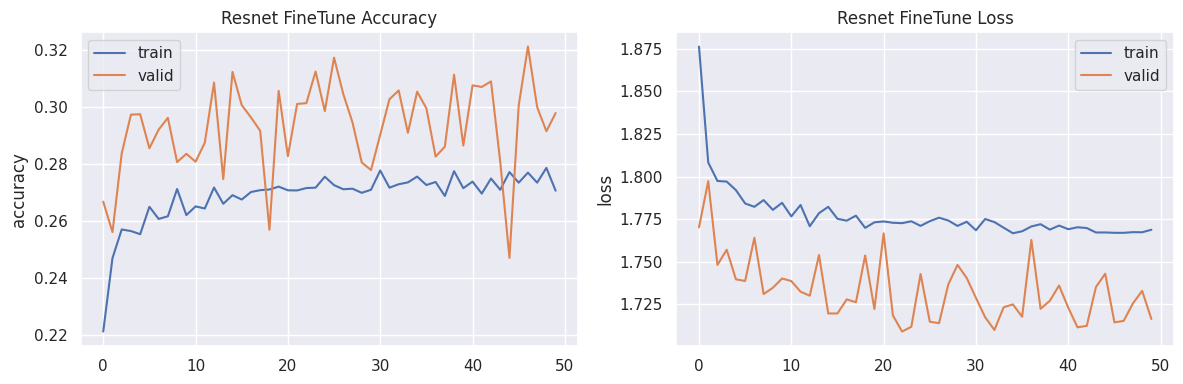

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(data=history_resnet_FineTune_dict, x=history_resnet_FineTune.epoch, y='accuracy', label='train')
sns.lineplot(data=history_resnet_FineTune_dict, x=history_resnet_FineTune.epoch, y='val_accuracy', label='valid')
plt.title('Resnet FineTune Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=history_resnet_FineTune_dict, x=history_resnet_FineTune.epoch, y='loss', label='train')
sns.lineplot(data=history_resnet_FineTune_dict, x=history_resnet_FineTune.epoch, y='val_loss', label='valid')
plt.title('Resnet FineTune Loss')
plt.tight_layout()

plt.savefig('epoch_history_res_FT.png')
plt.show()

226/226 [==============================] - 4s 13ms/step
total wrong validation predictions: 5134


              precision    recall  f1-score   support

           0       0.24      0.18      0.21       958
           1       0.00      0.00      0.00       111
           2       0.39      0.03      0.06      1044
           3       0.28      0.85      0.42      1774
           4       0.31      0.08      0.13      1243
           5       0.26      0.09      0.13      1247
           6       0.50      0.18      0.26       831

    accuracy                           0.29      7208
   macro avg       0.28      0.20      0.17      7208
weighted avg       0.31      0.29      0.21      7208



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


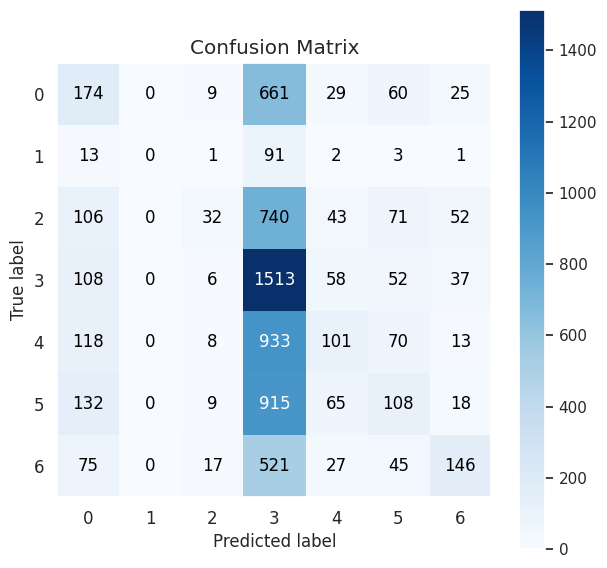

In [ ]:
yhat_vgg_test = resnet_model_finetuned.predict(X_test)
yhat_vgg_test = np.argmax(yhat_vgg_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(Y_test_one_hot, axis=1), yhat_vgg_test, figsize=(7,7))
plt.savefig("confusion_matrix_res_FT.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(Y_test_one_hot, axis=1) != yhat_vgg_test)}\n\n')
print(classification_report(np.argmax(Y_test_one_hot, axis=1), yhat_vgg_test))

##  **3. VGG model**

In [ ]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Use pre-trained ImageNet weights
    include_top=False,   # Exclude the fully-connected layers
    input_shape=(48, 48, 3))

base_model.trainable = False  # Freeze pre-trained layers

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model_VGG = tf.keras.Sequential([
    base_model,  # Pre-trained base model
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

model_VGG.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history_VGG = model_VGG.fit(
      x_train,
      y_train_ohe,
      epochs=50,
      validation_data=(x_val, y_val_one_hot)
    )

history_VGG_dict = history_VGG.history

Epoch 1/50
675/675 [==============================] - 15s 19ms/step - loss: 4.0052 - accuracy: 0.2581 - val_loss: 1.7598 - val_accuracy: 0.3202
Epoch 2/50
675/675 [==============================] - 11s 16ms/step - loss: 1.7341 - accuracy: 0.3184 - val_loss: 1.6570 - val_accuracy: 0.3448
Epoch 3/50
675/675 [==============================] - 11s 16ms/step - loss: 1.6650 - accuracy: 0.3432 - val_loss: 1.6410 - val_accuracy: 0.3645
Epoch 4/50
675/675 [==============================] - 11s 17ms/step - loss: 1.6295 - accuracy: 0.3578 - val_loss: 1.6329 - val_accuracy: 0.3780
Epoch 5/50
675/675 [==============================] - 14s 20ms/step - loss: 1.6030 - accuracy: 0.3663 - val_loss: 1.6174 - val_accuracy: 0.3722
Epoch 6/50
675/675 [==============================] - 14s 20ms/step - loss: 1.5864 - accuracy: 0.3799 - val_loss: 1.6053 - val_accuracy: 0.3736
Epoch 7/50
675/675 [==============================] - 14s 20ms/step - loss: 1.5695 - accuracy: 0.3873 - val_loss: 1.6028 - val_accuracy:

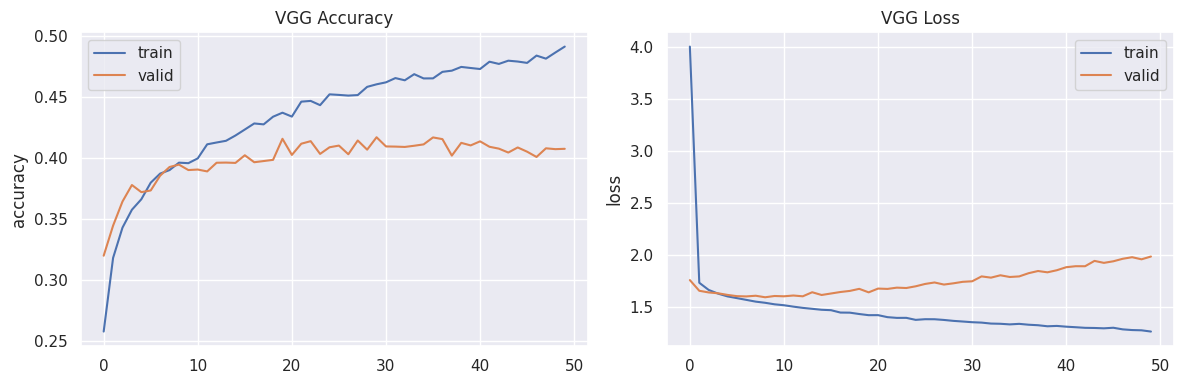

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(data=history_VGG_dict, x=history_VGG.epoch, y='accuracy', label='train')
sns.lineplot(data=history_VGG_dict, x=history_VGG.epoch, y='val_accuracy', label='valid')
plt.title('VGG Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=history_VGG_dict, x=history_VGG.epoch, y='loss', label='train')
sns.lineplot(data=history_VGG_dict, x=history_VGG.epoch, y='val_loss', label='valid')
plt.title('VGG Loss')
plt.tight_layout()

plt.savefig('epoch_history_vgg.png')
plt.show()

### **Curve Interpretation**

Validation Accuracy remains at around 42%.
Validation Loss increases slowly overtime.

=> It seems that the VGG model is overfitting the dataset

226/226 [==============================] - 3s 13ms/step
total wrong validation predictions: 4266


              precision    recall  f1-score   support

           0       0.36      0.23      0.28       958
           1       1.00      0.06      0.12       111
           2       0.35      0.24      0.29      1044
           3       0.42      0.71      0.53      1774
           4       0.33      0.41      0.37      1243
           5       0.39      0.25      0.30      1247
           6       0.72      0.45      0.55       831

    accuracy                           0.41      7208
   macro avg       0.51      0.34      0.35      7208
weighted avg       0.42      0.41      0.39      7208



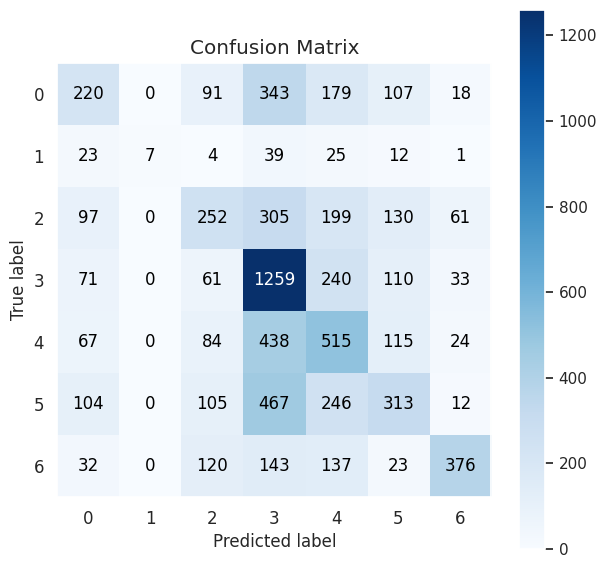

In [ ]:
yhat_vgg_test = model_VGG.predict(X_test)
yhat_vgg_test = np.argmax(yhat_vgg_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(Y_test_one_hot, axis=1), yhat_vgg_test, figsize=(7,7))
plt.savefig("confusion_matrix_vgg.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(Y_test_one_hot, axis=1) != yhat_vgg_test)}\n\n')
print(classification_report(np.argmax(Y_test_one_hot, axis=1), yhat_vgg_test))

### **Matrix interpretation**

6 & 3 : 'surprise' & 'happy' respectively have the best F1 scores, relationship between precision & recall.
The confusion Matrix seems to have a more distinct diagonal, indicator of actual predictions' improvement when using VGG model.

Despite the relatively small sample size of 'surprise', the VGG model does particularly well in recognizing that emotion ( be it in recall or precision )

**==> The VGG model could be used to complement other models that perform poorly for 'surprise' emotion.**

*Note : these predictions were obtained with a VGG that overfits the data, further finetuning of the model will likely give better results.*

## 4 . InceptionV3

Cannot be used beacuase the minimum size of input data is 75*75

In [ ]:
Inception_base_model = tf.keras.applications.InceptionV3(weights='imagenet',
                                include_top=False,
                                input_shape=(48, 48,3))
Inception_base_model.trainable = False

add_model = tf.keras.layers.Sequential()
add_model.add(Inception_base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(tf.keras.layers.Dense(7, activation='softmax'))

Inception_model = add_model

# C. Data Generation : 'Disgust'

### 1. Loading Disgust dataset

In [ ]:
# This is a function that loads data from a sub directory reltive to one emotion

def load_data_One_Emotion(Sub_dir_path,ohe, img_size=(48,48)):
    X = []  # contains images' arrays
    Y = []  # contains images' one hot encoded value
    i = 0


    for file in os.listdir(Sub_dir_path ):
        if not file.startswith('.'):
            img = cv2.imread(Sub_dir_path +'/' + file)
            X.append(img)
            Y.append(ohe[Sub_dir_path[52:]])
            i += 1

    X = np.array(X)
    y = np.array(Y)
    print(f'{len(X)} images loaded from {Sub_dir_path} directory.')
    return X, y

In [ ]:
Sub_train_dir = url_1 +'/train/disgust'   # Change emotion according to subdirectory, chosen disgust beacause it's the dataset with the least samples.
#X_train_Emotion, y_train_Emotion, _ = load_data(Sub_train_dir)

In [ ]:
Sub_train_dir[61:]

'disgust'

In [ ]:
X_disgust_gen, y_disgust_gen = load_data_One_Emotion(Sub_train_dir,ohe)

436 images loaded from /content/drive/MyDrive/1. Emotions Recognition/Dataset/train/disgust directory.


In [ ]:
Sub_ycbr_dir = train_YCBR + '/disgust'
Sub_ycbr_dir[52:]

'disgust'

In [ ]:
X_disgust_ycbr,_ = load_data_One_Emotion(Sub_ycbr_dir,ohe)

436 images loaded from /content/drive/MyDrive/1. Emotions Recognition/YCBR/disgust directory.


In [ ]:
print('X_disgust_gen shape = ',X_disgust_gen.shape)
print('X_disgust_ycbr shape = ',X_disgust_ycbr.shape)

X_disgust_gen shape =  (436, 48, 48, 3)
X_disgust_ycbr shape =  (436, 48, 48, 3)


### 2. Generating for the fitting

In [ ]:
Sub_train_dir
train = url_1 +'/train'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input


# Assuming you have a directory structure with subdirectories for each class
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(48, 48),
    batch_size=128,
    class_mode='categorical'
)


Found 28771 images belonging to 7 classes.


# D. Final Model Testing & Evaluation

# **I. Final Model 1 : RESNET Finetuned + VGG**

## 1. Data Integration

In [ ]:
print('x_train shape = ',x_train.shape)
print('X_Gauss shape = ',X_Gauss.shape)
print('X_YCBR shape = ',X_YCBR.shape)
print('X_YES shape = ',X_YES.shape)

x_train shape =  (21578, 48, 48, 3)
X_Gauss shape =  (24665, 48, 48, 3)
X_YCBR shape =  (27388, 48, 48, 3)
X_YES shape =  (28771, 48, 48, 3)


In [ ]:
x_concat_data=np.concatenate((x_train,X_Gauss,X_YCBR,X_YES), axis=0)
x_concat_data.shape

(77737, 48, 48, 3)

In [ ]:
y_concat_data=np.concatenate((y_train_ohe,Y_Gauss_one_hot,Y_YCBR_one_hot,Y_YES_one_hot), axis=0)
y_concat_data.shape

(77737, 7)

In [ ]:
output1 = resnet_model_finetuned.layers[-2].output  # output before the flatten layer
output2 = model_VGG.layers[-2].output  # output before the flatten layer

merged = tf.keras.layers.Concatenate()([output1, output2])

# Adding dense layers
merged = tf.keras.layers.Dense(64, activation='relu')(merged)
merged = tf.keras.layers.Dense(64, activation='relu')(merged)
merged = tf.keras.layers.Dense(7, activation='softmax')(merged)

# Create a new model
Final_model = tf.keras.models.Model(inputs=[resnet_model_finetuned.input,model_VGG.input], outputs=merged)


In [ ]:
Final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 2. Integrated model fitting

In [ ]:
history_Final = Final_model.fit(
      [x_concat_data],
      y_concat_data,
      epochs=50,
      validation_data=(x_val,y_val)
    )

history_Final_dict = history_Final.history

Fitting on Disgust generated data

In [ ]:
Final_model.fit_generator(
    train_generator,
    epochs=30
)

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(data=history_Final_dict, x=history_Final.epoch, y='accuracy', label='train')
sns.lineplot(data=history_Final_dict, x=history_Final.epoch, y='val_accuracy', label='valid')
plt.title('Final Model 1 Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=history_Final_dict, x=history_Final.epoch, y='loss', label='train')
sns.lineplot(data=history_Final_dict, x=history_Final.epoch, y='val_loss', label='valid')
plt.title('Final Model 1 Loss')
plt.tight_layout()

plt.savefig('epoch_history_Final_1.png')
plt.show()

## 3. Testing & Evaluation

In [ ]:
yhat_vgg_test = Final_model.predict(X_test)
yhat_vgg_test = np.argmax(yhat_vgg_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(Y_test_one_hot, axis=1), yhat_vgg_test, figsize=(7,7))
plt.savefig("confusion_matrix_FM_1.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(Y_test_one_hot, axis=1) != yhat_vgg_test)}\n\n')
print(classification_report(np.argmax(Y_test_one_hot, axis=1), yhat_vgg_test))

# **II. Final Model 2 : Model CNN updated + VGG**

## 1. Model integration

In [ ]:
base_model_F = tf.keras.applications.VGG16(
    weights='imagenet',  # Use pre-trained ImageNet weights
    include_top=False,   # Exclude the fully-connected layers
    input_shape=(48, 48, 3))

base_model_F.trainable = False  # Freeze pre-trained layers

Final_model_2 = tf.keras.Sequential([
    base_model_F,  # Pre-trained base model
    Model_12_update.layers[-2], #updated CNN model

    # Finetuning part of initial vgg
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

Final_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## 2. Fitting

In [ ]:
history_Final_2 = Final_model_2.fit(
      x_concat_data,
      y_concat_data,
      epochs=50,
      validation_data=( x_concat_data,y_concat_data)
    )

history_Final_2_dict = history_Final_2.history

Fitting on Disgust generated data

In [ ]:
# Now, you can use train_generator to fit your model
Final_model_2.fit_generator(
    train_generator,
    epochs=30
)

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(data=history_Final_2_dict, x=history_Final_2.epoch, y='accuracy', label='train')
sns.lineplot(data=history_Final_2_dict, x=history_Final_2.epoch, y='val_accuracy', label='valid')
plt.title('Final Model 2 Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(data=history_Final_2_dict, x=history_Final_2.epoch, y='loss', label='train')
sns.lineplot(data=history_Final_2_dict, x=history_Final_2.epoch, y='val_loss', label='valid')
plt.title('Final Model 2 Loss')
plt.tight_layout()

plt.savefig('epoch_history_Final_2.png')
plt.show()

## 3. Testing & Evaluation

In [ ]:
yhat_vgg_test = Final_model_2.predict(X_test)
yhat_vgg_test = np.argmax(yhat_vgg_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(np.argmax(Y_test_one_hot, axis=1), yhat_vgg_test, figsize=(7,7))
plt.savefig("confusion_matrix_FM_2.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(Y_test_one_hot, axis=1) != yhat_vgg_test)}\n\n')
print(classification_report(np.argmax(Y_test_one_hot, axis=1), yhat_vgg_test))